<h1><center>Hierarchical Clustering</center></h1>

Welcome to Lab of Hierarchical Clustering with Python using Scipy and Scikit-learn package.

We will be looking at a clustering technique, which is <b>Agglomerative Hierarchical Clustering</b>. Remember that agglomerative is the bottom up approach. <br> <br>
In this lab, we will be looking at Agglomerative clustering, which is more popular than Divisive clustering. <br> <br>
We will also be using Complete Linkage as the Linkage Criteria. <br>
<b> <i> NOTE: You can also try using Average Linkage wherever Complete Linkage would be used to see the difference! </i> </b>

In [5]:
import numpy as np 
import pandas as pd
from scipy import ndimage 
from scipy.cluster import hierarchy 
from scipy.spatial import distance_matrix 
from matplotlib import pyplot as plt 
from sklearn import manifold, datasets 
from sklearn.cluster import AgglomerativeClustering 
from sklearn.datasets.samples_generator import make_blobs 
%matplotlib inline

## Read data
lets read dataset to see what features the manufacturer has collected about the existing models.

In [6]:
filename = 'cars_clus.csv'

#Read csv
pdf = pd.read_csv(filename)
print ("Shape of dataset: ", pdf.shape)

pdf.head(5)

Shape of dataset:  (159, 16)


,manufact,model,sales,resale,type,price,engine_s,horsepow,wheelbas,width,length,curb_wgt,fuel_cap,mpg,lnsales,partition
0,Acura,Integra,16.919,16.360,0.000,21.500,1.800,140.000,101.200,67.300,172.400,2.639,13.200,28.000,2.828,0.0
1,Acura,TL,39.384,19.875,0.000,28.400,3.200,225.000,108.100,70.300,192.900,3.517,17.200,25.000,3.673,0.0
2,Acura,CL,14.114,18.225,0.000,$null$,3.200,225.000,106.900,70.600,192.000,3.470,17.200,26.000,2.647,0.0
3,Acura,RL,8.588,29.725,0.000,42.000,3.500,210.000,114.600,71.400,196.600,3.850,18.000,22.000,2.150,0.0
4,Audi,A4,20.397,22.255,0.000,23.990,1.800,150.000,102.600,68.200,178.000,2.998,16.400,27.000,3.015,0.0


The feature sets include  price in thousands (price), engine size (engine_s), horsepower (horsepow), wheelbase (wheelbas), width (width), length (length), curb weight (curb_wgt), fuel capacity (fuel_cap) and fuel efficiency (mpg).

<h2 id="data_cleaning">Data Cleaning</h2>
lets simply clear the dataset by dropping the rows that have null value:

In [7]:
print ("Shape of dataset before cleaning: ", pdf.size)
pdf[[ 'sales', 'resale', 'type', 'price', 'engine_s',
       'horsepow', 'wheelbas', 'width', 'length', 'curb_wgt', 'fuel_cap',
       'mpg', 'lnsales']] = pdf[['sales', 'resale', 'type', 'price', 'engine_s',
       'horsepow', 'wheelbas', 'width', 'length', 'curb_wgt', 'fuel_cap',
       'mpg', 'lnsales']].apply(pd.to_numeric, errors='coerce')
pdf = pdf.dropna()
pdf = pdf.reset_index(drop=True)
print ("Shape of dataset after cleaning: ", pdf.size)
pdf.head(5)

Shape of dataset before cleaning:  2544
Shape of dataset after cleaning:  1872


,manufact,model,sales,resale,type,price,engine_s,horsepow,wheelbas,width,length,curb_wgt,fuel_cap,mpg,lnsales,partition
0,Acura,Integra,16.919,16.360,0.0,21.50,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0,2.828,0.0
1,Acura,TL,39.384,19.875,0.0,28.40,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,3.673,0.0
2,Acura,RL,8.588,29.725,0.0,42.00,3.5,210.0,114.6,71.4,196.6,3.850,18.0,22.0,2.150,0.0
3,Audi,A4,20.397,22.255,0.0,23.99,1.8,150.0,102.6,68.2,178.0,2.998,16.4,27.0,3.015,0.0
4,Audi,A6,18.780,23.555,0.0,33.95,2.8,200.0,108.7,76.1,192.0,3.561,18.5,22.0,2.933,0.0


### Feature selection
Lets select our feature set:

In [8]:
featureset = pdf[['engine_s',  'horsepow', 'wheelbas', 'width', 'length', 'curb_wgt', 'fuel_cap', 'mpg']]

### Normalization
Now we can normalize the feature set. __MinMaxScaler__ transforms features by scaling each feature to a given range. It is by default (0, 1). That is, this estimator scales and translates each feature individually such that it is between zero and one.

In [9]:
from sklearn.preprocessing import MinMaxScaler
x = featureset.values #returns a numpy array
min_max_scaler = MinMaxScaler()
feature_mtx = min_max_scaler.fit_transform(x)
feature_mtx [0:5]

array([[0.11428571, 0.21518987, 0.18655098, 0.28143713, 0.30625832,
        0.2310559 , 0.13364055, 0.43333333],
       [0.31428571, 0.43037975, 0.3362256 , 0.46107784, 0.5792277 ,
        0.50372671, 0.31797235, 0.33333333],
       [0.35714286, 0.39240506, 0.47722343, 0.52694611, 0.62849534,
        0.60714286, 0.35483871, 0.23333333],
       [0.11428571, 0.24050633, 0.21691974, 0.33532934, 0.38082557,
        0.34254658, 0.28110599, 0.4       ],
       [0.25714286, 0.36708861, 0.34924078, 0.80838323, 0.56724368,
        0.5173913 , 0.37788018, 0.23333333]])

<h2 id="clustering_using_scipy">Clustering using Scipy</h2>
In this part we use Scipy package to cluster the dataset:  
First, we calculate the distance matrix. 

In [10]:
import scipy
leng = feature_mtx.shape[0]
D = scipy.zeros([leng,leng])
for i in range(leng):
    for j in range(leng):
        D[i,j] = scipy.spatial.distance.euclidean(feature_mtx[i], feature_mtx[j])

In agglomerative clustering, at each iteration, the algorithm must update the distance matrix to reflect the distance of the newly formed cluster with the remaining clusters in the forest. 
The following methods are supported in Scipy for calculating the distance between the newly formed cluster and each:
    - single
    - complete
    - average
    - centroid
    
    
We use __complete__ for our case, but feel free to change it to see how the results change.

In [11]:
import pylab
import scipy.cluster.hierarchy
Z = hierarchy.linkage(D, 'complete')

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  This is separate from the ipykernel package so we can avoid doing imports until


Essentially, Hierarchical clustering does not require a pre-specified number of clusters. However, in some applications we want a partition of disjoint clusters just as in flat clustering.
So you can use a cutting line:

In [12]:
from scipy.cluster.hierarchy import fcluster
max_d = 3
clusters = fcluster(Z, max_d, criterion='distance')
clusters

array([ 1,  5,  5,  6,  5,  4,  6,  5,  5,  5,  5,  5,  4,  4,  5,  1,  6,
        5,  5,  5,  4,  2, 11,  6,  6,  5,  6,  5,  1,  6,  6, 10,  9,  8,
        9,  3,  5,  1,  7,  6,  5,  3,  5,  3,  8,  7,  9,  2,  6,  6,  5,
        4,  2,  1,  6,  5,  2,  7,  5,  5,  5,  4,  4,  3,  2,  6,  6,  5,
        7,  4,  7,  6,  6,  5,  3,  5,  5,  6,  5,  4,  4,  1,  6,  5,  5,
        5,  6,  4,  5,  4,  1,  6,  5,  6,  6,  5,  5,  5,  7,  7,  7,  2,
        2,  1,  2,  6,  5,  1,  1,  1,  7,  8,  1,  1,  6,  1,  1],
      dtype=int32)

Also, you can determine the number of clusters directly:

In [13]:
from scipy.cluster.hierarchy import fcluster
k = 5
clusters = fcluster(Z, k, criterion='maxclust')
clusters


array([1, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 2, 2, 3, 1, 3, 3, 3, 3, 2, 1,
       5, 3, 3, 3, 3, 3, 1, 3, 3, 4, 4, 4, 4, 2, 3, 1, 3, 3, 3, 2, 3, 2,
       4, 3, 4, 1, 3, 3, 3, 2, 1, 1, 3, 3, 1, 3, 3, 3, 3, 2, 2, 2, 1, 3,
       3, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 2, 1, 3, 3, 3, 3, 3, 2,
       3, 2, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 3, 3, 1, 1, 1,
       3, 4, 1, 1, 3, 1, 1], dtype=int32)

Now, plot the dendrogram:

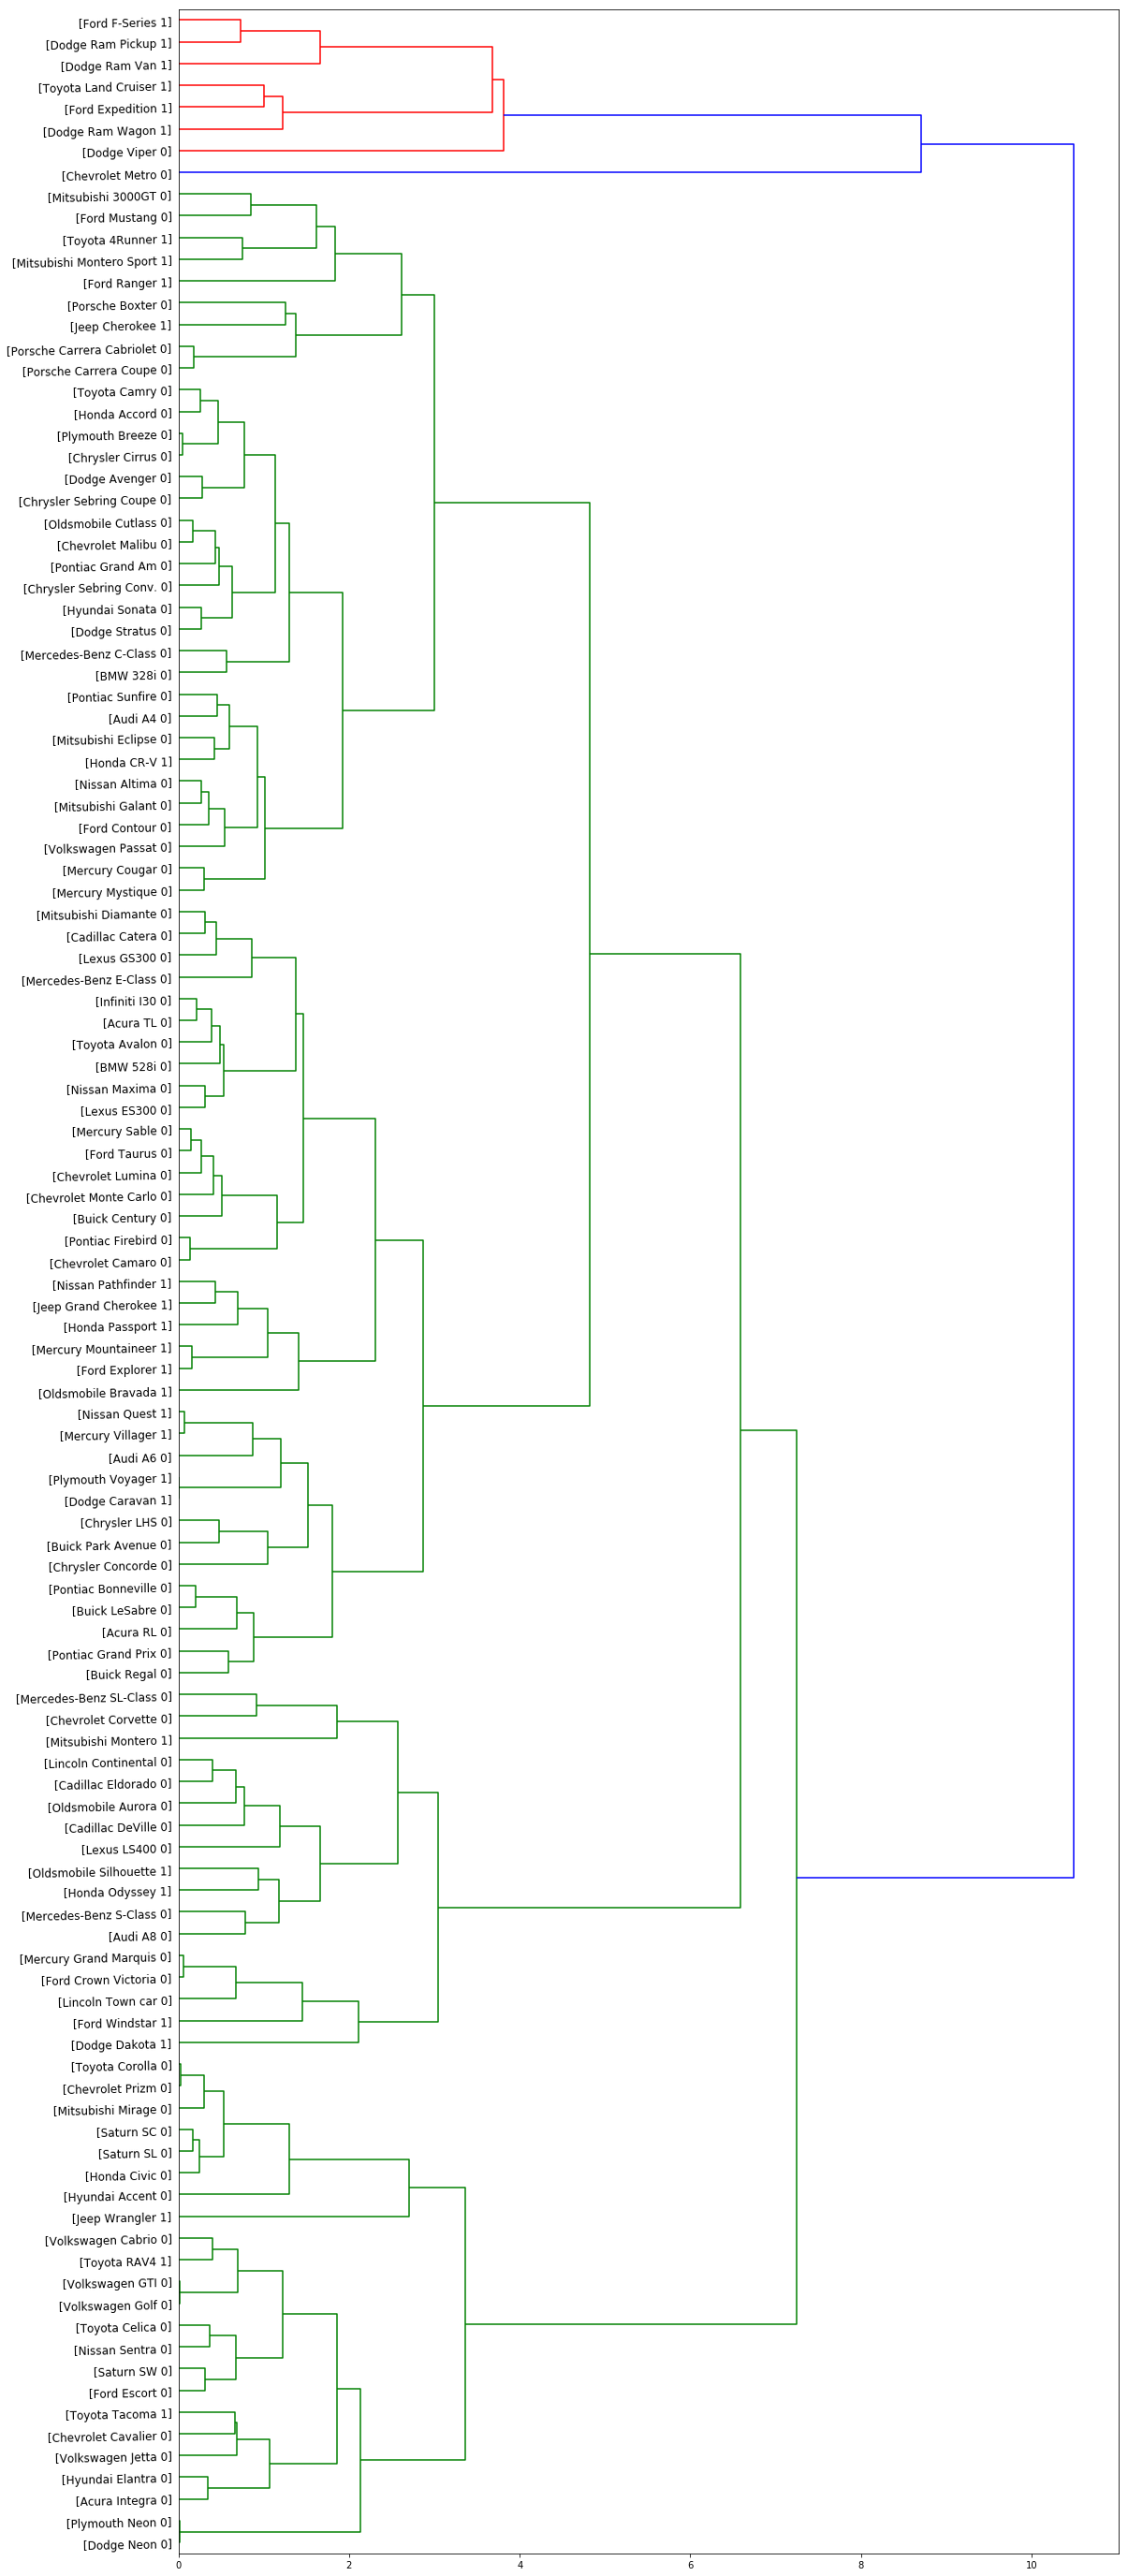

In [15]:
fig = pylab.figure(figsize=(18,50))
def llf(id):
    return '[%s %s %s]' % (pdf['manufact'][id], pdf['model'][id], int(float(pdf['type'][id])) )
    
dendro = hierarchy.dendrogram(Z,  leaf_label_func=llf, leaf_rotation=0, leaf_font_size =12, orientation = 'right')